In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34839,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:40211,Total threads: 1
Dashboard: /proxy/40417/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:42259,


In [3]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)
cc.querying.get_ncfiles(session,experiment='10_KDS50')

,ncfile,index_time
0,ocean_temp_salt.res.nc,2022-09-25 12:41:19.463709
1,woa13_ts_01_mom10.nc,2022-09-25 12:41:15.926621
2,woa13_ts_02_mom10.nc,2022-09-25 12:41:16.925326
3,woa13_ts_03_mom10.nc,2022-09-25 12:41:14.793881
4,woa13_ts_04_mom10.nc,2022-09-25 12:41:18.222727
5,woa13_ts_05_mom10.nc,2022-09-25 12:41:12.691469
6,woa13_ts_06_mom10.nc,2022-09-25 12:41:17.568369
7,woa13_ts_07_mom10.nc,2022-09-25 12:41:10.689479
8,woa13_ts_08_mom10.nc,2022-09-25 12:41:18.854977
9,woa13_ts_09_mom10.nc,2022-09-25 12:41:13.763954


In [22]:
from collections import OrderedDict
exptdict = OrderedDict([
    ('HI-00', # original historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-00',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
    ('HI-02', # Pacific Pacemaker historical run
     {'model': 'ACCESS-ESM 1.5', 'expt': 'HI-02',
      'n_files': -12, 'itime': '1850-01-14', 'ftime': None}),
])

In [23]:
# Add on pre-interpolated WOA13 directories for every run:
for ekey in exptdict.keys():
    e = exptdict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

In [25]:
# Function to extract and load SST and SSS from the models, WOA13
ekeys = ['HI-00', 'HI-02']
for ekey in ekeys:
    e = exptdict[ekey]

    # SST
    # -----

    # Load surface temperature from model
    surface_temp = cc.querying.getvar(e['expt'], 'pot_temp', session,
                            n=e['n_files'], ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)

    # Extract a year range string and print (for title string):
    e['yearrange'] = "{} to {}".format(
        surface_temp.time.item(0), #.strftime("%Y-%m"),
        surface_temp.time.item(-1), #.strftime("%Y-%m"),
    )
    print(f"{ekey}: {e['yearrange']}")

    # Add SST to dictionary
    e['SST'] = surface_temp.mean('time').load()

    # Load WOA13 SST and add to dictionary
    # ignore warning about ambiguous files
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SST_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session).isel(ZT=0).mean('time').load()

    # Calculate bias and add to dictionary
    SST_anom = e['SST'] - e['SST_WOA13'].values
    e['SST_anom'] = SST_anom.load()

    # SSS
    # -----
    surface_salt = cc.querying.getvar(e['expt'], 'salt', session,
                            n=e['n_files'],ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)
    e['SSS'] = surface_salt.mean('time').load()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SSS_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt',session).isel(ZT=0).mean('time').load()
    SSS_anom = e['SSS'] - e['SSS_WOA13'].values
    e['SSS_anom'] = SSS_anom.load()

HI-00: -3375432000000000000 to -2999419200000000000
HI-02: -3375432000000000000 to -2999419200000000000


In [30]:
def plot_SST(ekeys):
    clev = np.arange(-3,3.25,0.25)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='gray', linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SST_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev, add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))

        if i == 1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['HI-00']
    ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SST_WOA13'].plot.contourf(cmap=cm.cm.thermal,levels=np.arange(-2.,32.,1.),add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92,0.52,0.01,0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SST anomaly (°C)')

    ax6 = plt.axes([0.92,0.13,0.01,0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SST (°C)')



def plot_SSS(ekeys):
    clev = np.arange(-1.5, 1.6, 0.1)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='gray',linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1, projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SSS_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev, add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))

        if i == 1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['HI-00']
    ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SSS_WOA13'].plot.contourf(cmap=cm.cm.thermal, levels=np.arange(31., 36.2, 0.2), add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92, 0.52, 0.01, 0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SSS anomaly (psu)')

    ax6 = plt.axes([0.92, 0.13, 0.01, 0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SSS (psu)')

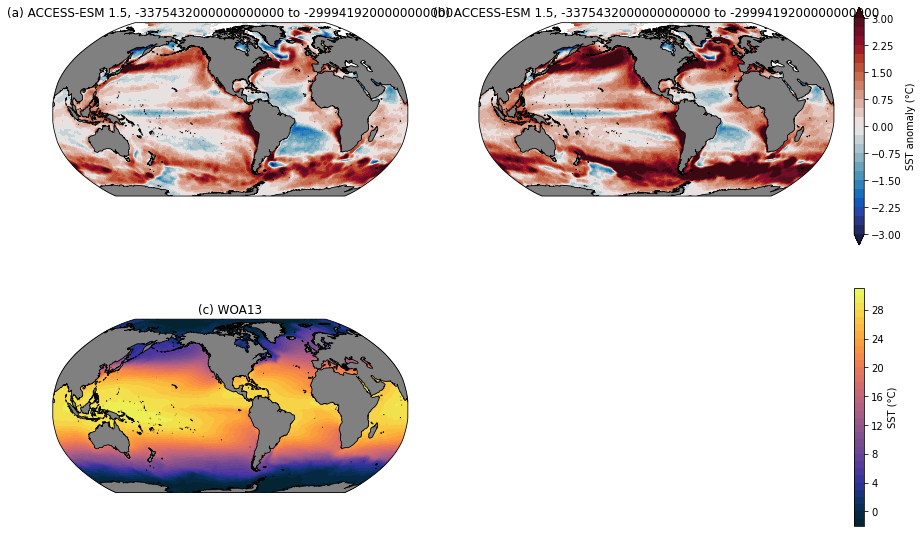

In [31]:
# Plot IAF and RYF SST biases at 3 resolutions:
fig = plt.figure(figsize=(14, 10))
ekeys = ['HI-00','HI-02']
plot_SST(ekeys)
#savefigure('SST_bias_IAF_RYF')

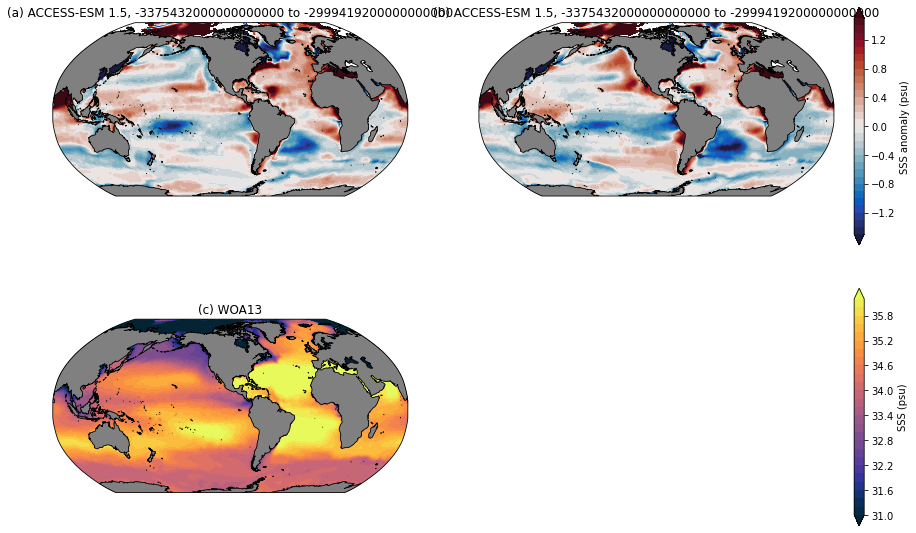

In [32]:
# Plot IAF and RYF SSS biases at 3 resolutions:
fig = plt.figure(figsize=(14, 10))
ekeys = ['HI-00','HI-02']
plot_SSS(ekeys)
#savefigure('SSS_bias_IAF_RYF')

In [34]:
# Define list of experiments to load (useful for testing):
ekeys = ['HI-00', 'HI-02']

# Loop through models
for ekey in ekeys:
    e = exptdict[ekey]

    # Load temperature
    eq_temp = cc.querying.getvar(e['expt'], 'pot_temp',session,
                 n=e['n_files'], ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0, method='nearest')

    # Set a text string to add the year range in title.
    e['yearrange'] = "{} to {}".format(
        eq_temp.time.item(0), #.strftime("%Y-%m"),
        eq_temp.time.item(-1), #.strftime("%Y-%m"),
    )
    print(f"{ekey}: {e['yearrange']}")

    # Extract the WOA13 data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_temp_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session).sel(GRID_Y_T=0., method='nearest').mean('time')

    # Calculate the bias
    eq_temp_anom = eq_temp.mean('time') - e['eq_temp_WOA13'].values
    eq_temp_anom.attrs['units'] = 'degrees Celsius'

    e['eq_temp_anom'] = eq_temp_anom.load()

    # Do salt as for temperature above
    eq_salt = cc.querying.getvar(e['expt'], 'salt',session,
                 n=e['n_files'], ncfile='ocean_month.nc',
                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0,method='nearest')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_salt_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt',session).sel(GRID_Y_T=0.,method='nearest').mean('time')
    eq_salt_anom = eq_salt.mean('time') - e['eq_salt_WOA13'].values
    e['eq_salt_anom'] = eq_salt_anom.load()

HI-00: -3375432000000000000 to -2999419200000000000
HI-02: -3375432000000000000 to -2999419200000000000


In [35]:
# Define a function to plot Equatorial Slices of temperature:
def plot_eqtemp(ekeys):

    # Define contour levels
    clev = np.arange(-3.,3.25,0.25)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)

        # Plot bias as color
        pn = e['eq_temp_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)

        # Plot WOA13 isotherms (and 20C bold)
        CS = e['eq_temp_WOA13'].plot.contour(levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        e['eq_temp_WOA13'].plot.contour(levels=[20.], colors='k', linewidths=3.)
        (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.], colors='k', linewidths=3., linestyles='--')

        # Add annotations
        plt.title("({}) {},  {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')

        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isotherms', fontsize=15)
            p0 = pn

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

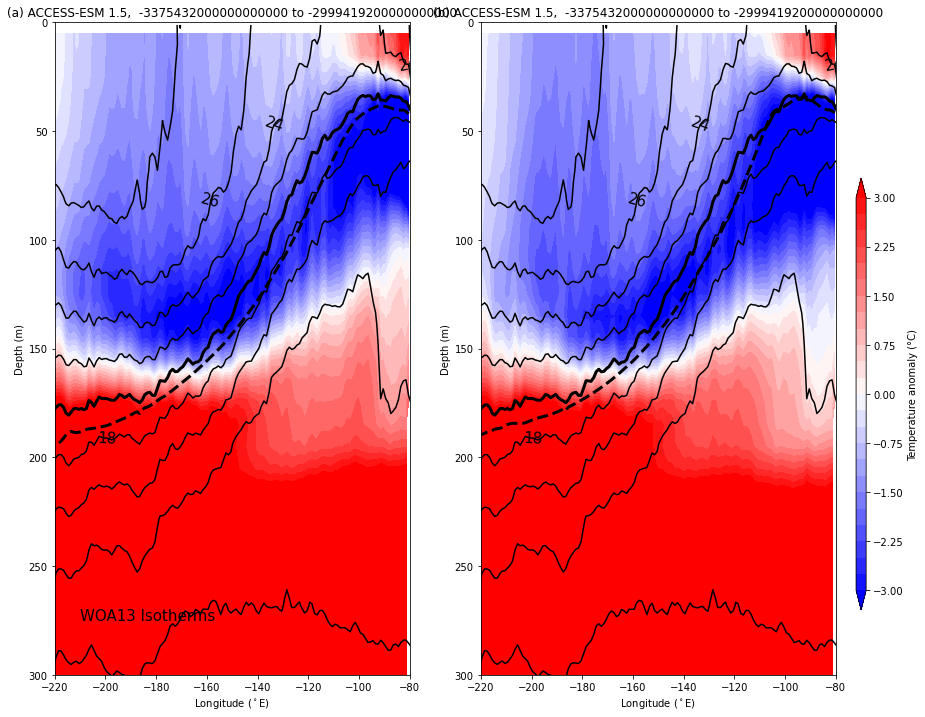

In [36]:
# Plot comparison of IAF simulations for temperature
fig = plt.figure(figsize=(14, 12))
ekeys = ['HI-00', 'HI-02']
plot_eqtemp(ekeys)

In [37]:
# Define a function to plot Equatorial Slices of salinity
def plot_eqsalt(ekeys):

    # Define contour levels
    clev = np.arange(-1., 1.1, 0.1)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)

        # Plot bias as color
        pn = e['eq_salt_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)

        # Plot WOA13 salinity (and 20C bold)
        CS = e['eq_salt_WOA13'].plot.contour(levels=np.arange(30., 36.1, 0.1), colors='k')
        ax1.clabel(CS, inline=False, fmt='%3.2f', fontsize=15)

        # Add annotations
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300.,0.])
        ax1.set_xlim([-220.,-80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')

        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isohalines', fontsize=15)
            p0 = pn

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Salinity anomaly (psu)')

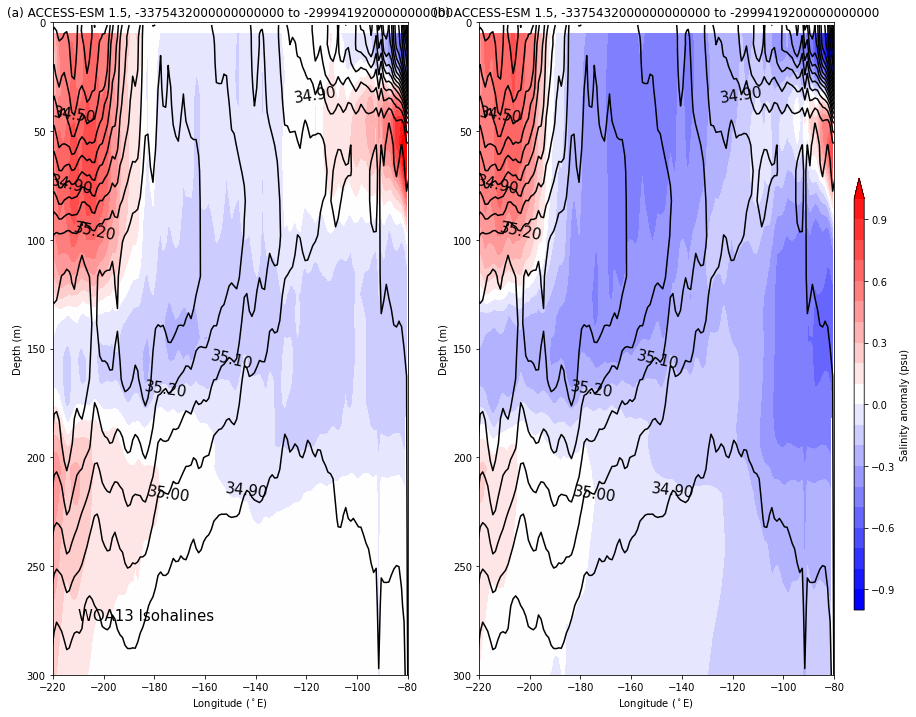

In [38]:
# Plot comparing IAF simulations for salinity
fig = plt.figure(figsize=(14, 12))
ekeys = ['HI-00', 'HI-02']
plot_eqsalt(ekeys)